## **Install library**

In [ ]:
!pip install gdown

## **Import libraries**

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gdown
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Input,LSTM, Dense, Dropout

## **Load and observe data**

In [54]:
url = 'https://drive.google.com/uc?id=14qSmoyVkiECmyOmuicIZho-2N4_hILvz'
output = 'T1.csv'
gdown.download(url, output, quiet=True)

data = pd.read_csv("T1.csv", parse_dates=[0])
data['Date/Time'] = pd.to_datetime(data['Date/Time'], format='%d %m %Y %H:%M')
data.set_index('Date/Time', inplace=True)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50530 entries, 2018-01-01 00:00:00 to 2018-12-31 23:50:00
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LV ActivePower (kW)            50530 non-null  float64
 1   Wind Speed (m/s)               50530 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 3   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4)
memory usage: 1.9 MB


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


## **Exploratory data analysis**

In [55]:
# Summary statistics
print(data.describe())

       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307.684332          7.557952                    1492.175463   
std            1312.459242          4.227166                    1368.018238   
min              -2.471405          0.000000                       0.000000   
25%              50.677890          4.201395                     161.328167   
50%             825.838074          7.104594                    1063.776283   
75%            2482.507568         10.300020                    2964.972462   
max            3618.732910         25.206011                    3600.000000   

       Wind Direction (°)  
count        50530.000000  
mean           123.687559  
std             93.443736  
min              0.000000  
25%             49.315437  
50%             73.712978  
75%            201.696720  
max            359.997589  


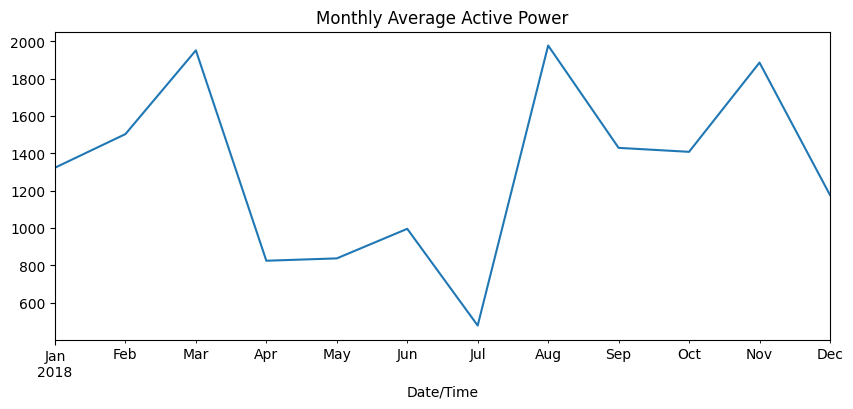

In [56]:
# Seasonal analysis
plt.figure(figsize=(10, 4))
data.resample('M').mean()['LV ActivePower (kW)'].plot()
plt.title('Monthly Average Active Power')
plt.show()

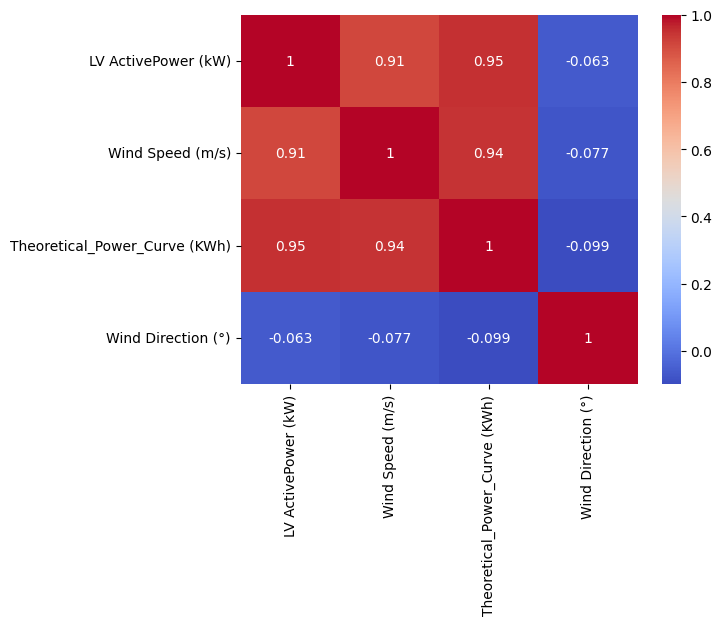

In [57]:
# Correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## **Anomaly detection**

In [60]:
# Handle missing values by filling them with the mean
data.fillna(data.mean(), inplace=True)

# Normalizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Split data into training and test sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Retain the original index for plotting
test_data_dates = data.index[train_size:]

# Isolation Forest for anomaly detection
model_if = IsolationForest(n_estimators=100, contamination=0.01)
model_if.fit(train_data)

# Predicting anomalies on the test set
test_pred_if = model_if.predict(test_data)
anomalies_if = np.where(test_pred_if == -1)[0]

# LSTM Autoencoder for anomaly detection
def create_lstm_autoencoder(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape[1], input_shape[2])))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(input_shape[2], activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape data for LSTM
train_data_reshaped = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
test_data_reshaped = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

# Train the LSTM Autoencoder
with tf.device('/gpu:0'):
  lstm_autoencoder = create_lstm_autoencoder(train_data_reshaped.shape)
  lstm_autoencoder.fit(train_data_reshaped, train_data_reshaped, epochs=20, batch_size=32, validation_split=0.1)

# Predicting anomalies on the test set
test_pred_lstm = lstm_autoencoder.predict(test_data_reshaped)
mse = np.mean(np.power(test_data_reshaped - test_pred_lstm, 2), axis=1)
anomalies_lstm = np.where(mse > np.percentile(mse, 99))[0]

Epoch 1/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.0162 - val_loss: 0.8665
Epoch 2/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.0033 - val_loss: 0.8461
Epoch 3/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 1.0144 - val_loss: 0.8544
Epoch 4/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1.0129 - val_loss: 0.8513
Epoch 5/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.0057 - val_loss: 0.8535
Epoch 6/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0113 - val_loss: 0.8513
Epoch 7/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.0155 - val_loss: 0.8498
Epoch 8/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0122 - val_loss: 0.8579
Epoch 9/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 1.0145 - val_loss: 0.8381
Epoch 10/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0079 - val_loss: 0.8630
Epoch 11/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.0116 - val_loss: 0.8555
Epoch 12/20
1137/1137 ━━━━

## **Visualization of results**

<ipython-input-59-837c5c902130>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(dates[anomalies], data[anomalies], color='red', label='Anomalies')


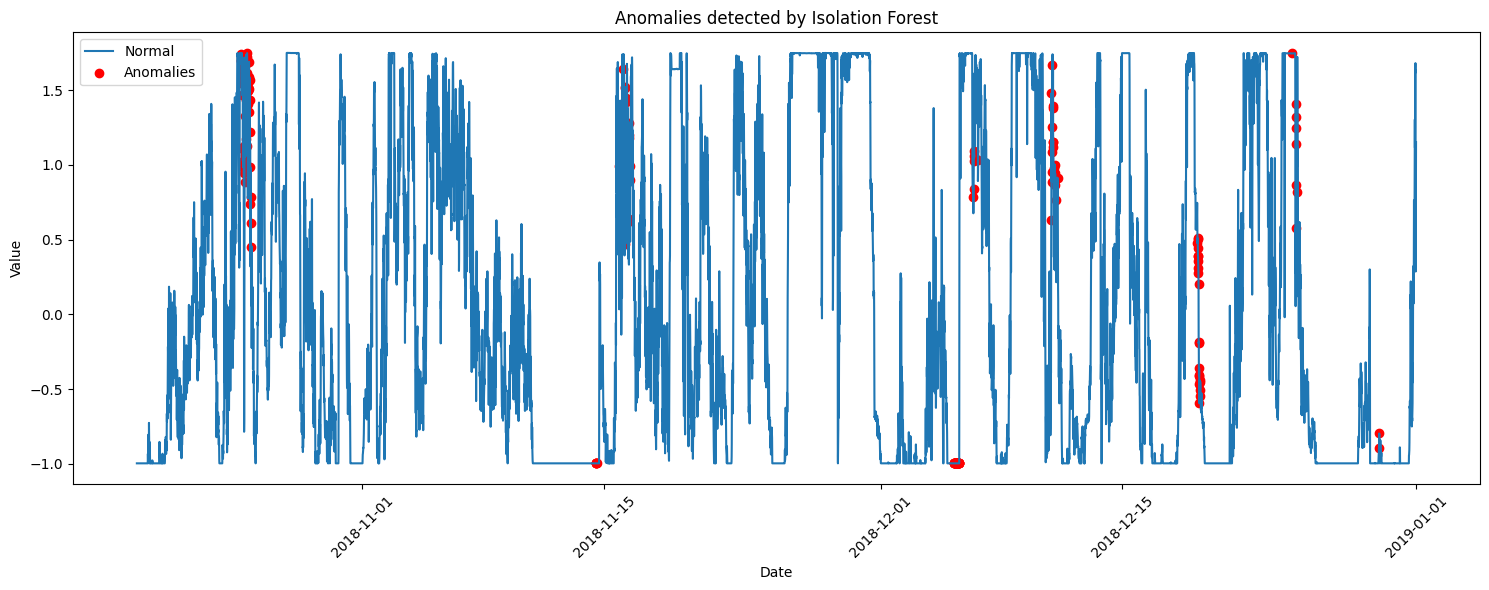

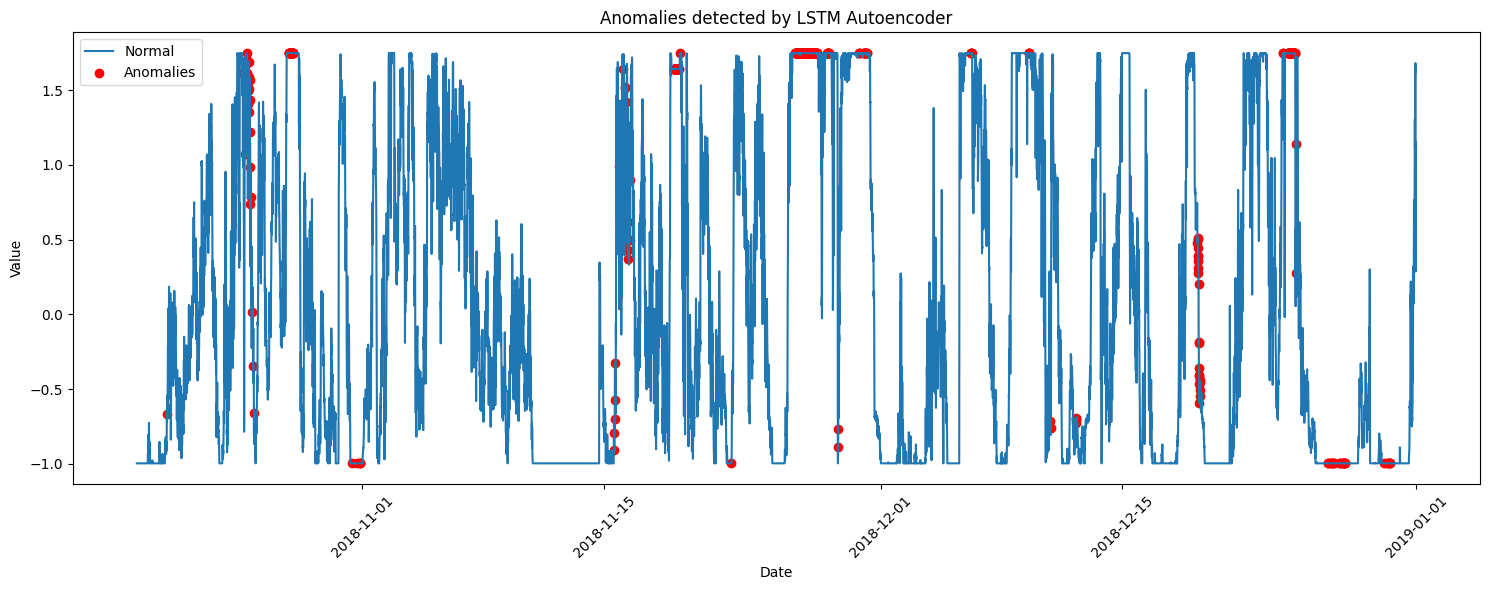

In [59]:
def plot_anomalies(dates, data, anomalies, title):
    plt.figure(figsize=(15, 6))
    plt.plot(dates, data, label='Normal')
    plt.scatter(dates[anomalies], data[anomalies], color='red', label='Anomalies')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

test_data_df = pd.DataFrame(test_data[:, 0], index=test_data_dates, columns=['LV ActivePower (kW)'])

# Plotting anomalies detected by Isolation Forest
plot_anomalies(test_data_dates, test_data_df['LV ActivePower (kW)'], anomalies_if, 'Anomalies detected by Isolation Forest')

# Plotting anomalies detected by LSTM Autoencoder
plot_anomalies(test_data_dates, test_data_df['LV ActivePower (kW)'], anomalies_lstm, 'Anomalies detected by LSTM Autoencoder')